# LIVER CIRRHOSIS PREDICTION

Liver cirrhosis is a widespread problem especially in North America due to high intake of alcohol. In this project, we will predict liver cirrhosis in a patient based on certain lifestyle and health conditions of a patient.

Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism.

# About Data 🗄
The data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

The dataset consists of following columns :
1. ID: unique identifier
2. N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3. Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4. Drug: type of drug D-penicillamine or placebo
5. Age: age in [days]
6. Sex: M (male) or F (female)
7. Ascites: presence of ascites N (No) or Y (Yes)
8. Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9. Spiders: presence of spiders N (No) or Y (Yes)
10. Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11. Bilirubin: serum bilirubin in [mg/dl]
12. Cholesterol: serum cholesterol in [mg/dl]
13. Albumin: albumin in [gm/dl]
14. Copper: urine copper in [ug/day]
15. Alk_Phos: alkaline phosphatase in [U/liter]
16. SGOT: SGOT in [U/ml]
17. Triglycerides: triglicerides in [mg/dl]
18. Platelets: platelets per cubic [ml/1000]
19. Prothrombin: prothrombin time in seconds [s]
20. Stage: histologic stage of disease (1, 2, 3, or 4)

# Importing necessary libraries

In [37]:
import warnings
import itertools

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from colorama import Fore, Back, Style
from yellowbrick.classifier import ROCAUC

sns.set_style('dark')
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)

# Lets Load the data and have a quick look.

In [2]:
df = pd.read_csv('cirrhosis.csv', index_col='ID')
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [3]:
df.shape

(418, 19)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

This data set has about 19 features. These features are related to the patient’s details like age, sex, etc. and patient’s blood tests like prothrombin, triglycerides, platelets levels, etc. All these factors help in understanding a patient’s chances of liver cirrhosis.

We have some NA values in our data, lets look at some statistical summary of numerical columns in out dataset.

# Lets look at the Descriptive Statistics of the data

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Age,418.0,18533.351675,3815.845055,9598.00,15644.5000,18628.00,21272.50,28650.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,284.0,369.510563,231.944545,120.00,249.5000,309.50,400.00,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,310.0,97.648387,85.613920,4.00,41.2500,73.00,123.00,588.00
Alk_Phos,312.0,1982.655769,2140.388824,289.00,871.5000,1259.00,1980.00,13862.40
SGOT,312.0,122.556346,56.699525,26.35,80.6000,114.70,151.90,457.25
Tryglicerides,282.0,124.702128,65.148639,33.00,84.2500,108.00,151.00,598.00
Platelets,407.0,257.024570,98.325585,62.00,188.5000,251.00,318.00,721.00


## We have some missing values in our data, lets see how many and in which columns.

In [6]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [7]:
df.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')

In [8]:
df.select_dtypes(include=(['int64', 'float64'])).isna().sum()
df_num_col = df.select_dtypes(include=(['int64', 'float64'])).columns
for c in df_num_col:
    df[c].fillna(df[c].median(), inplace=True)

df.select_dtypes(include=(['int64', 'float64'])).isna().sum()

N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [9]:
# For Categorical type
df.select_dtypes(include=('object')).isna().sum()

Status            0
Drug            106
Sex               0
Ascites         106
Hepatomegaly    106
Spiders         106
Edema             0
dtype: int64

In [10]:
df_cat_col = df.select_dtypes(include=('object')).columns
for c in df_cat_col:
    df[c].fillna(df[c].mode().values[0], inplace=True)
    
df.select_dtypes(include=('object')).isna().sum()

Status          0
Drug            0
Sex             0
Ascites         0
Hepatomegaly    0
Spiders         0
Edema           0
dtype: int64

In [11]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'N_Days': [ 400 4500 1012 1925 1504 2503 1832 2466 2400   51 3762  304 3577 1217
 3584 3672  769  131 4232 1356 3445  673  264 4079 4127 1444   77  549
 4509  321 3839 4523 3170 3933 2847 3611  223 3244 2297 4467 1350 4453
 4556 3428 4025 2256 2576 4427  708 2598 3853 2386 1000 1434 1360 1847
 3282 4459 2224 4365 4256 3090  859 1487 3992 4191 2769 4039 1170 3458
 4196 4184 4190 1827 1191   71  326 1690 3707  890 2540 3574 4050 4032
 3358 1657  198 2452 1741 2689  460  388 3913  750  130 3850  611 3823
 3820  552 3581 3099  110 3086 3092 3222 3388 2583 2504 2105 2350  980
 3395 3422 3336 1083 2288  515 2033  191 3297  971 3069 2468  824 3255
 1037 3239 1413  850 2944 2796 3149 3150 3098 2990 1297 2106 3059 3050
 2419  786  943 2976 2615 2995 1427  762 2891 2870 1152 2863  140 2666
  853 2835 2475 1536 2772 2797  186 2055 1077 2721 1682 2713 1212 2692
 2574 2301 2657 2644 2624 1492 2609 2580 2573 2563 2556 2555 2241  974
 2527 1576  733 2332 2456  216 2443  797 24

Alright now our dataset contains no missing values 😌

# Exploratory Data Analysys
## Lets dive into the data and visualize it, this often revels interesting patterns.
First lets take a look at how many examples per calss do we have in our dataset.

In [12]:
df['Stage'].value_counts()

3.0    161
4.0    144
2.0     92
1.0     21
Name: Stage, dtype: int64

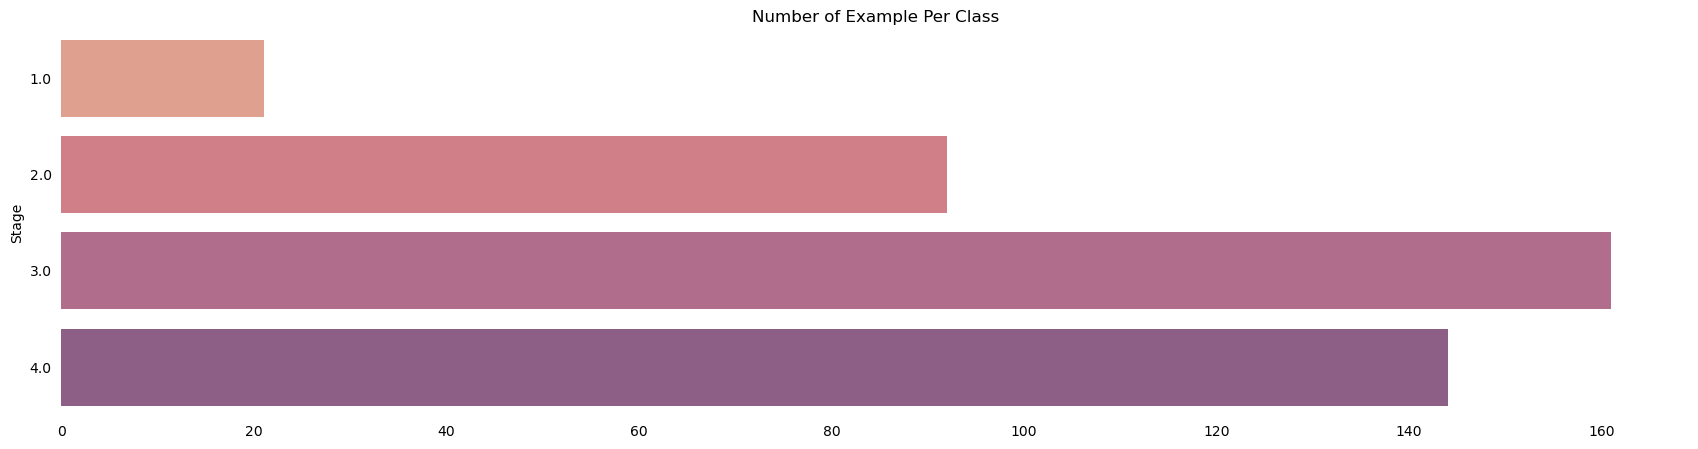

In [13]:
plt.figure(figsize=(21,5))
sns.countplot(y=df['Stage'], palette="flare", alpha=0.8, )
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Number of Example Per Class');

As we can observe we have class imbalances in our dataset i.e some classes have more examples than other. This could make it difficult for our model to train and achieve desired score. No worries, we can fix that later.

# Setting up Target and Features

### For this demonstration we will keep things simple by predicting one of the two classes  i.e (Cirrhosis and No Cirrhois). I have another project that predicts the stage of the disease, converting this problem into a multicalss classification.

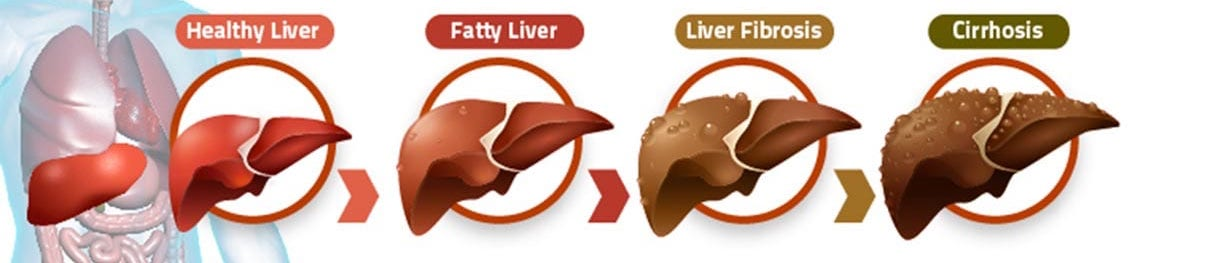

In [14]:
# Converting Target categories into integers 1 for Cirrhosis, 0 otherwise
df['Stage'] = np.where(df['Stage'] == 4,1,0)

## Lets observe some Features with their relation with the disease

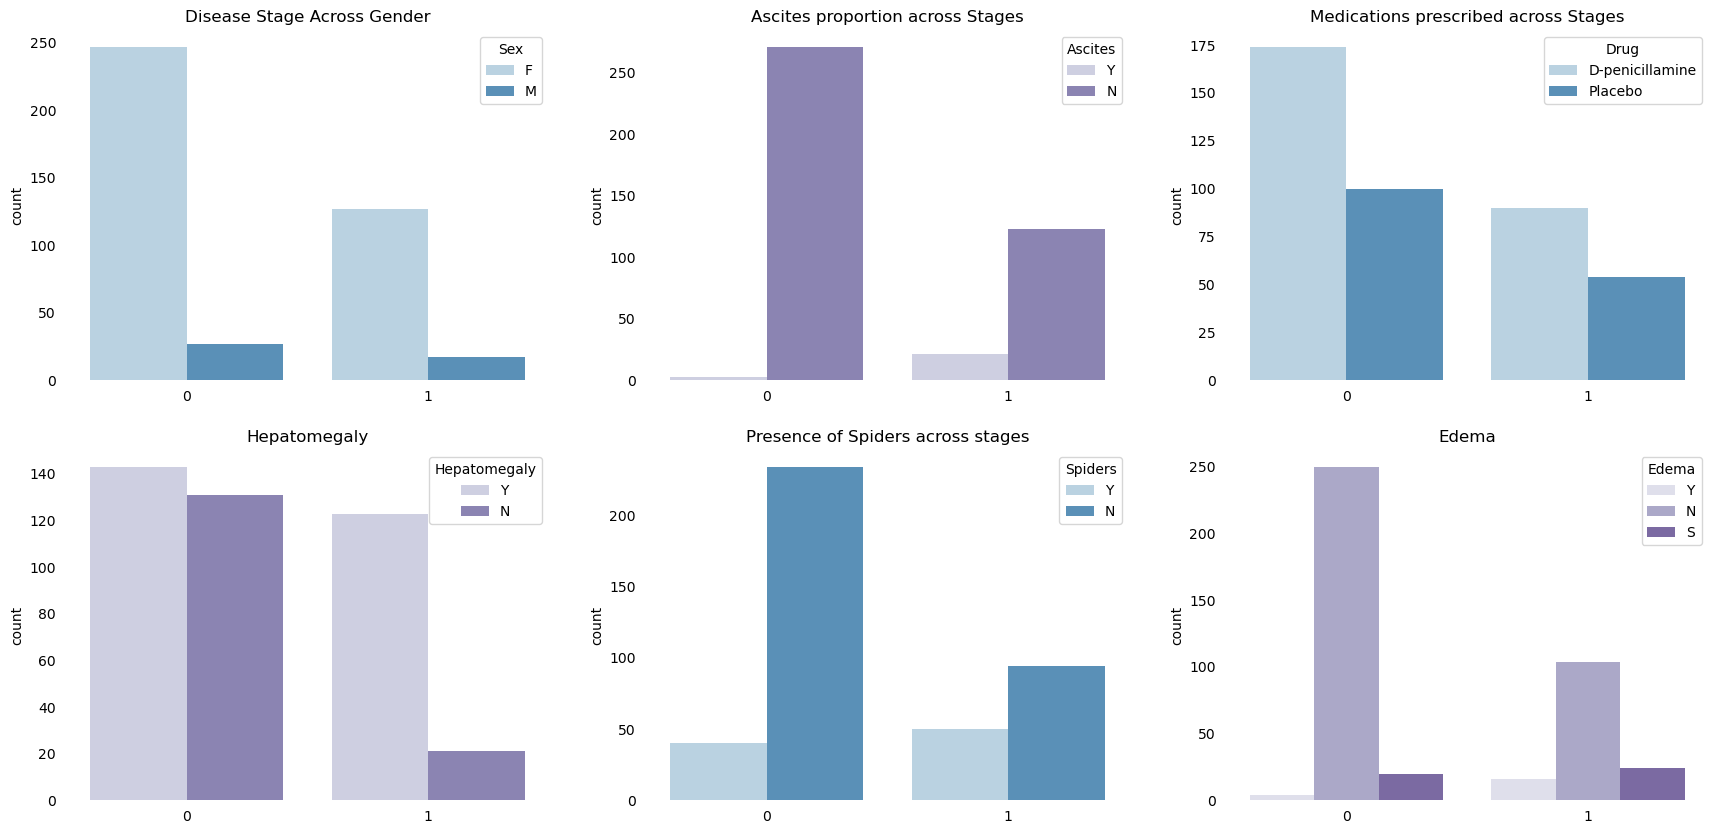

In [15]:
plt.figure(figsize=(21.2,10))

plt.subplot(2,3,1)
sns.countplot(x=df['Stage'], hue=df['Sex'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Disease Stage Across Gender')

plt.subplot(2,3,2)
sns.countplot(x=df['Stage'], hue=df['Ascites'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Ascites proportion across Stages')

plt.subplot(2,3,3)
sns.countplot(x=df['Stage'], hue=df['Drug'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Medications prescribed across Stages');

plt.subplot(2,3,4)
sns.countplot(x=df['Stage'], hue=df['Hepatomegaly'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Hepatomegaly');

plt.subplot(2,3,5)
sns.countplot(x=df['Stage'], hue=df['Spiders'], palette='Blues', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Presence of Spiders across stages');

plt.subplot(2,3,6)
sns.countplot(x=df['Stage'], hue=df['Edema'], palette='Purples', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Edema');

There are some interesting insights if we observe closely. Take the case at Ascites, we observe that the risk of disease is higher with increase in Ascites, also presence of spiders has a positive relation with disease risk.

# Visualising the data distributed across

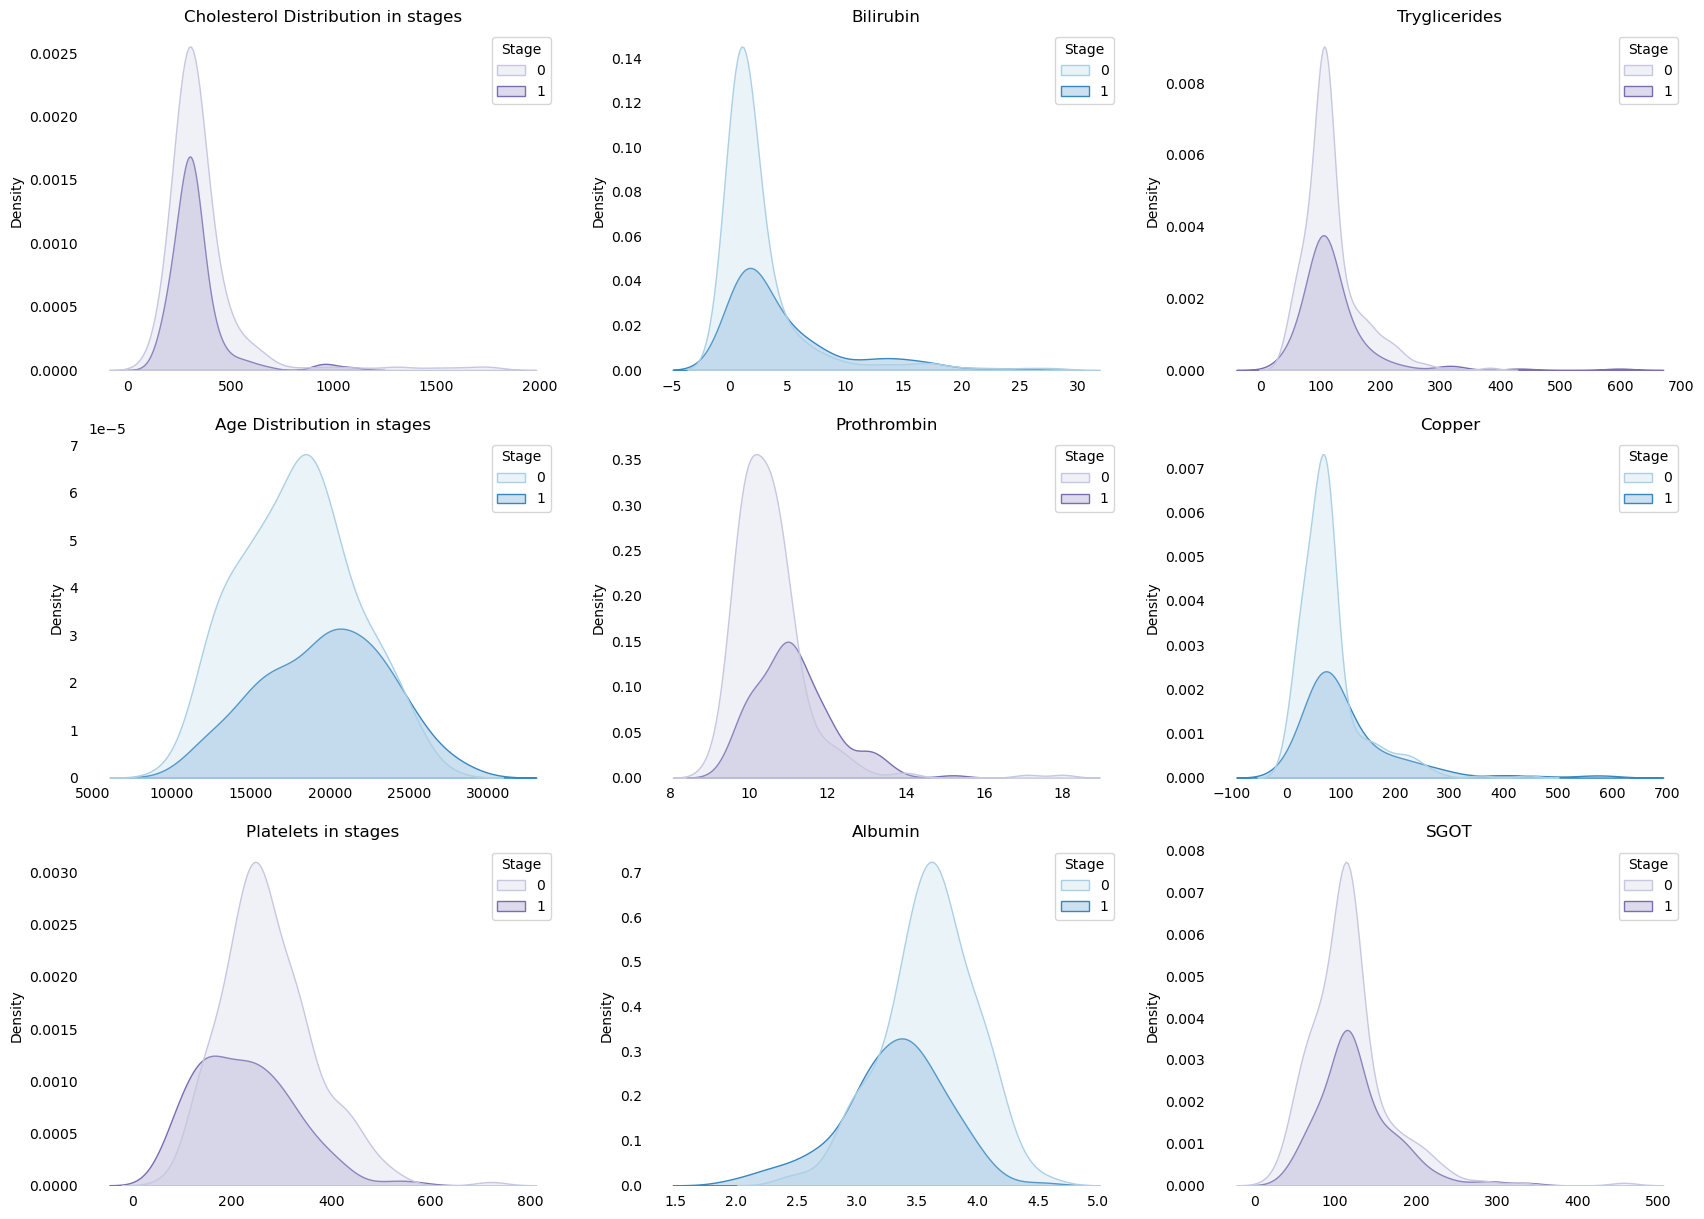

In [16]:
#Distribution Polts
plt.figure(figsize=(20.6,15))

plt.subplot(3,3,1)
sns.kdeplot(x=df['Cholesterol'], hue=df['Stage'], fill=True, palette='Purples')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Cholesterol Distribution in stages');

plt.subplot(3,3,2)
sns.kdeplot(x=df['Bilirubin'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Bilirubin');

plt.subplot(3,3,3)
sns.kdeplot(x=df['Tryglicerides'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Tryglicerides');

plt.subplot(3,3,4)
sns.kdeplot(x=df['Age'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Age Distribution in stages');

plt.subplot(3,3,5)
sns.kdeplot(x=df['Prothrombin'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Prothrombin');

plt.subplot(3,3,6)
sns.kdeplot(x=df['Copper'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Copper');

plt.subplot(3,3,7)
sns.kdeplot(x=df['Platelets'], hue=df['Stage'], fill=True, palette='Purples')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Platelets in stages');

plt.subplot(3,3,8)
sns.kdeplot(x=df['Albumin'], hue=df['Stage'], fill=True, palette='Blues', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('Albumin');

plt.subplot(3,3,9)
sns.kdeplot(x=df['SGOT'], hue=df['Stage'], fill=True, palette='Purples', common_norm=True)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('SGOT');

### Looking at the feature distribution we can observe that in features such as Age, Prothrombin, Copper the risk of the disease increase with increase in feature value, thus having a positive co-relation on with the disease probability. Lets fit a regression line to check.

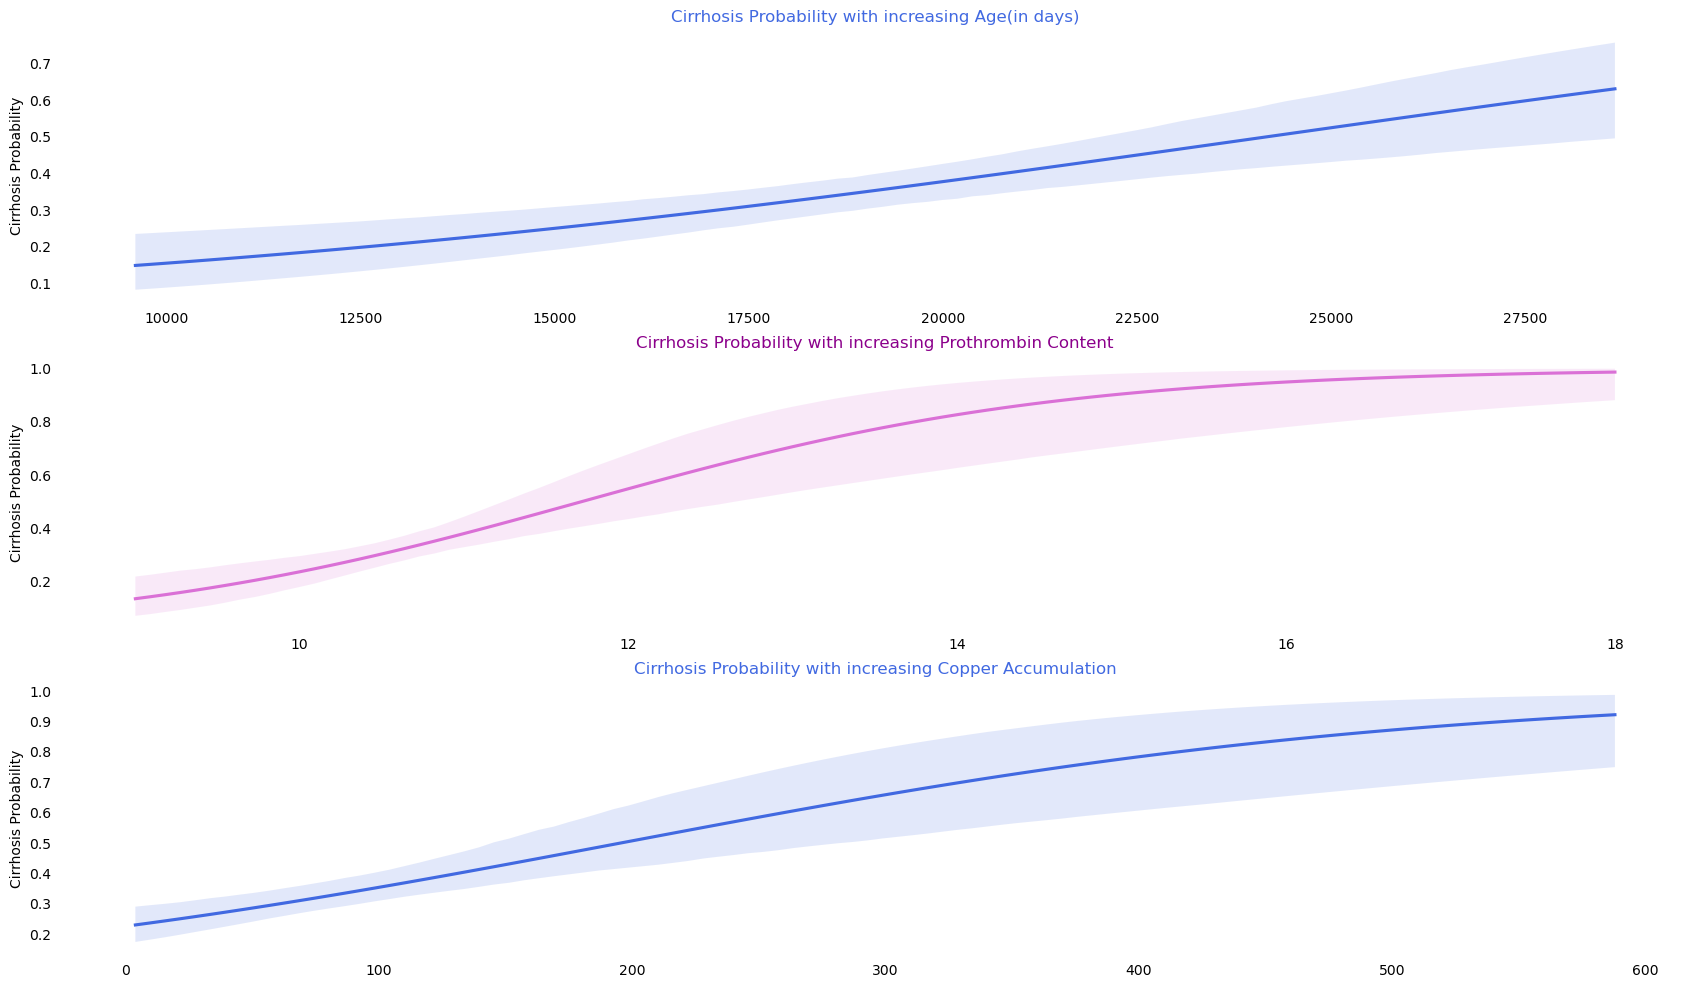

In [17]:
#Regression Plots of Positive Correlated Features.
plt.figure(figsize=(21,12))

plt.subplot(3,1,1)
sns.regplot(x=df['Age'], y=df['Stage'], scatter=False, logistic=True, color='royalblue')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with increasing Age(in days)'), color='royalblue') ;

plt.subplot(3,1,2)
sns.regplot(x=df['Prothrombin'], y=df['Stage'], scatter=False, logistic=True, color='orchid');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with increasing Prothrombin Content'), color='darkmagenta');

plt.subplot(3,1,3)
sns.regplot(x=df['Copper'], y=df['Stage'], scatter=False, logistic=True, color='royalblue')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with increasing Copper Accumulation'), color='royalblue') ;

Looks like the data checks with our intuition. These parameters indeed increase the risk of the disease.

### We can also observe some features such as Platelets, Albumin, Cholesterol where the probability of disease decrease with increase in feature value. Lets tally that with some more regression plots.

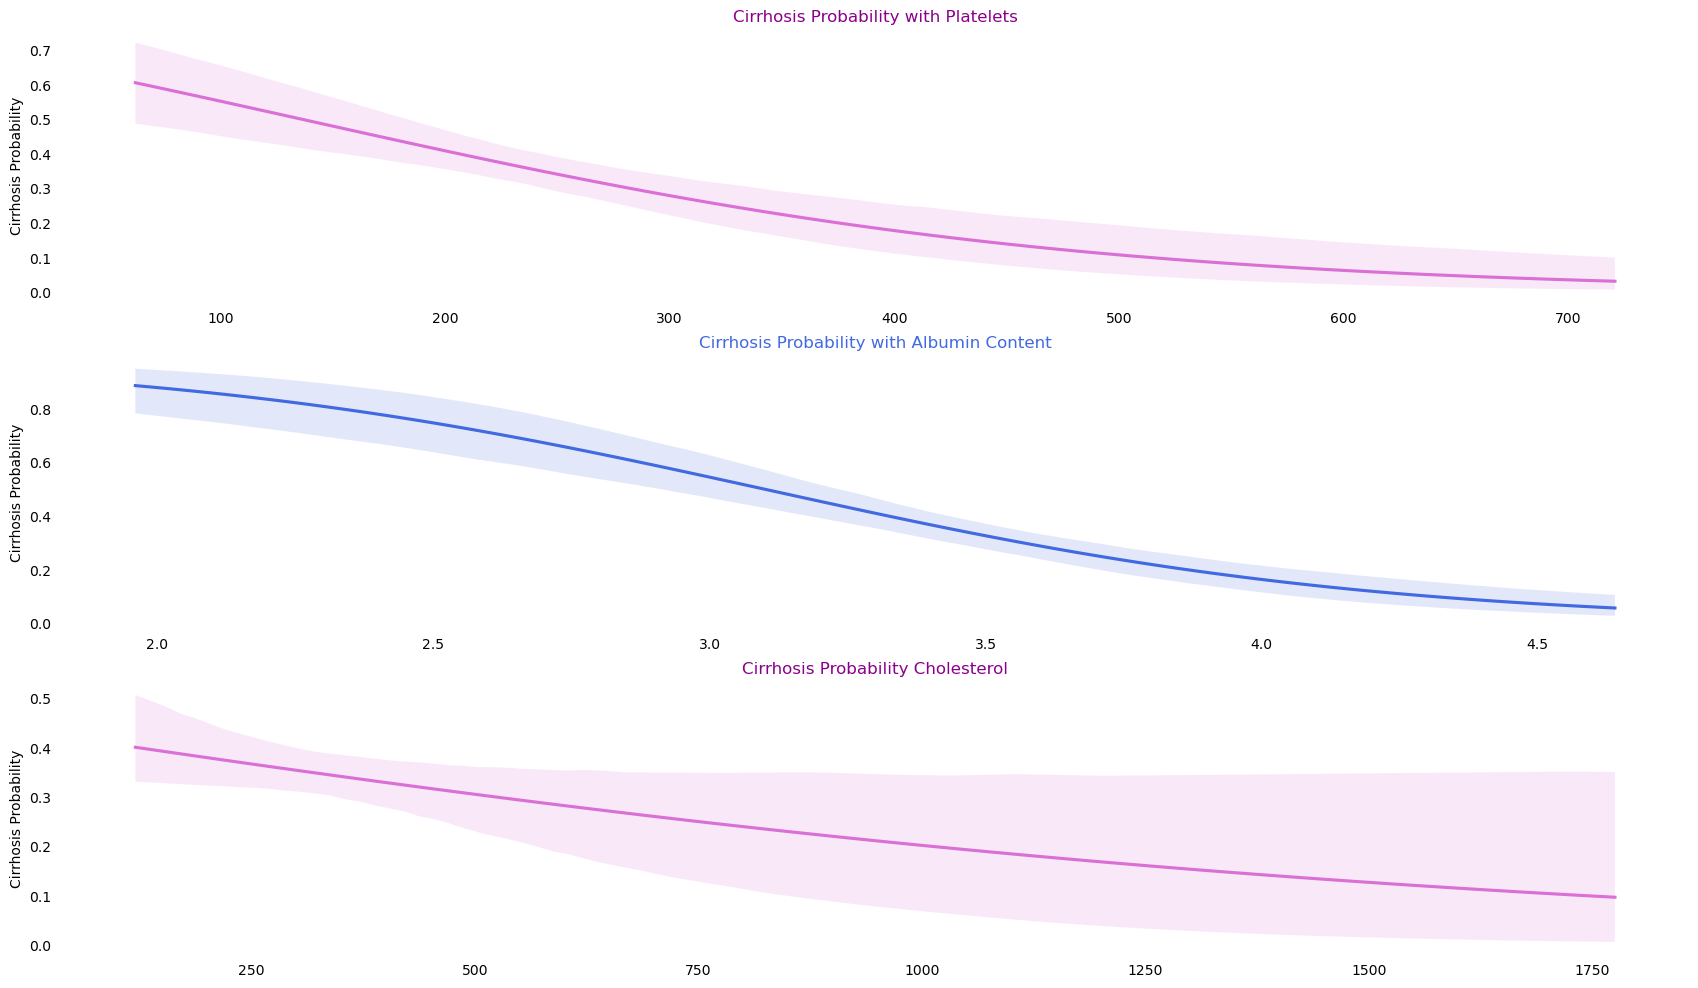

In [18]:
#Regression Plots of negatively correlated Features.
plt.figure(figsize=(21,12))

plt.subplot(3,1,1)
sns.regplot(x=df['Platelets'], y=df['Stage'], scatter=False, logistic=True, color='orchid')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with Platelets'), color='darkmagenta');

plt.subplot(3,1,2)
sns.regplot(x=df['Albumin'], y=df['Stage'], scatter=False, logistic=True, color='royalblue');
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability with Albumin Content'), color='royalblue');

plt.subplot(3,1,3)
sns.regplot(x=df['Cholesterol'], y=df['Stage'], scatter=False, logistic=True, color='orchid')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('');
plt.ylabel('Cirrhosis Probability');
plt.setp(plt.title('Cirrhosis Probability Cholesterol'), color='darkmagenta') ;

Platelets, Albumin checks with our logic the findings about Cholesterol seems interesting! Looks like people with high Cholesterol have lower risk of Cirrhosis, this might not sound correct but our data certainly shows so. 

This should help our model predict the target. We will be looking at what features contribute the most in later part of the project.

# Preprocessing the data

In [19]:
# replacing categorical data with integers.
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})                                # Male : 0 , Female :1
df['Ascites'] = df['Ascites'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1   
df['Drug'] = df['Drug'].replace({'D-penicillamine':0, 'Placebo':1})          # D-penicillamine : 0, Placebo : 1   
df['Hepatomegaly'] = df['Hepatomegaly'].replace({'N':0, 'Y':1})              # N : 0, Y : 1
df['Spiders'] = df['Spiders'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1
df['Edema'] = df['Edema'].replace({'N':0, 'Y':1, 'S':-1})                    # N : 0, Y : 1, S : -1
df['Status'] = df['Status'].replace({'C':0, 'CL':1, 'D':-1})                 # 'C':0, 'CL':1, 'D':-1

In [20]:
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,-1,0,21464,1,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,1
2,4500,0,0,20617,1,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,0
3,1012,-1,0,25594,0,0,0,0,-1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,1
4,1925,-1,0,19994,1,0,1,1,-1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,1
5,1504,1,1,13918,1,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,0


## We will not be using 'Status' and 'N_days' as our features since this will cause data Leakage.

In [21]:
# Setting up Features and Target
X = df.drop(['Status', 'N_Days', 'Stage'], axis=1)
Y= df.pop('Stage')

In [22]:
print(X)

     Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  Bilirubin  \
ID                                                                        
1       0  21464    1        1             1        1      1       14.5   
2       0  20617    1        0             1        1      0        1.1   
3       0  25594    0        0             0        0     -1        1.4   
4       0  19994    1        0             1        1     -1        1.8   
5       1  13918    1        0             1        1      0        3.4   
..    ...    ...  ...      ...           ...      ...    ...        ...   
414     0  24472    1        0             1        0      0        1.2   
415     0  14245    1        0             1        0      0        0.9   
416     0  20819    1        0             1        0      0        1.6   
417     0  21185    1        0             1        0      0        0.8   
418     0  19358    1        0             1        0      0        0.7   

     Cholesterol  Albumi

In [23]:
print(Y)

ID
1      1
2      0
3      1
4      1
5      0
      ..
414    0
415    1
416    0
417    0
418    1
Name: Stage, Length: 418, dtype: int32


In [24]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()

scaler.fit(X)
X=scaler.transform(X)

In [25]:
from sklearn.model_selection import train_test_split

#split into 80:20 ratio 
#Split the data into test and train
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2,random_state=10)

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(334, 16)
(334,)
(84, 16)
(84,)


In [29]:
from sklearn.linear_model import LogisticRegression
#create a model
classifier=LogisticRegression()
#fitting training data to the model
classifier.fit(X_train,y_train)

Y_pred=classifier.predict(X_test)
print(Y_pred)

[0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 1]


# **3- Modeling**

In [38]:
# Performance Comparison Visualization

def score_vis(score):
    
    names = ['SVM', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'AdaBoost', 'KNN']

    plt.rcParams['figure.figsize']=20,8
    ax = sns.barplot(x=names, y=score, palette = "plasma", saturation =2.0)
    plt.xlabel('Model', fontsize = 20 )
    plt.ylabel('Accuracy(%)', fontsize = 20)
    plt.title('Model Comparison - Test set', fontsize = 20)
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
    plt.show()

In [41]:
def trainer(X_train, y_train, X_test, y_test):
    
    models= [[' SVM ',SVC()],
             [' Decision Tree ', DecisionTreeClassifier()],
             [' Random Forest ', RandomForestClassifier()],
             [' Logistic Regression ', LogisticRegression(max_iter=200)],
             [' AdaBoost ', AdaBoostClassifier()],
             [' KNN ', KNeighborsClassifier()]]

    scores = []
    
    for model_name, model in models:

        model = model
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        cm_model = confusion_matrix(y_test, pred)
        scores.append(accuracy_score(y_test, model.predict(X_test)))
        

        print(Back.YELLOW + Fore.BLACK + Style.BRIGHT + model_name)
        print(Back.RESET)
        print(cm_model)
        print('\n' + Fore.BLUE + 'Training Acc.  : ' + Fore.GREEN + str(round(accuracy_score(y_train, model.predict(X_train)) * 100, 2)) + '%' )
        print(Fore.BLUE + 'Validation Acc.: ' + Fore.GREEN + str(round(accuracy_score(y_test, model.predict(X_test)) * 100, 2)) + '%' )
        print(Fore.CYAN + classification_report(y_test, pred)) 
          

        print('\n' + Fore.BLACK + Back.WHITE + '⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜\n')
    
        
    return scores

In [42]:
scores = trainer(X_train, y_train, X_test, y_test)

 SVM 

[[48  7]
 [14 15]]

Training Acc.  : 85.63%
Validation Acc.: 75.0%
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        55
           1       0.68      0.52      0.59        29

    accuracy                           0.75        84
   macro avg       0.73      0.69      0.70        84
weighted avg       0.74      0.75      0.74        84


⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

 Decision Tree 

[[41 14]
 [19 10]]

Training Acc.  : 100.0%
Validation Acc.: 60.71%
              precision    recall  f1-score   support

           0       0.68      0.75      0.71        55
           1       0.42      0.34      0.38        29

    accuracy                           0.61        84
   macro avg       0.55      0.55      0.55        84
weighted avg       0.59      0.61      0.60        84


⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

 Random Forest 

[[48  7]
 [11 18]]

Training Acc.  : 100.0%
Validation Acc.: 78.57%
              precisio

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
score_vis(scores)